This notebook uses the images of the extracted faces from the real/fake videos in a folder layout:

Images/
    Train/
        Real/
        Fake/
    Val/
        Real/
        Fake/

I used EfficientNet (B3) [1] with pre-trained imagenet weights as the baseline model. EfficientNet can be installed via "pip install -U efficientnet". I chose this model for the baseline due to its efficiency in managing the size of the overall network and performance. The layers from the efficient net were frozen and new trainable layers were added for fine-tuning. There is scope for unfreezing some pre-trained layers for better performance. 

The data generators used a rescale function of 1./255 as a form of normalising the pixel values. Zoom, shear, and horizontal flips were added transforms as it is common for a wide range of videos to contain faces of varying distances / shear / and orientations from/to the camera. There is scope for these transforms to be fine-tuned for better performance. 

[1] Tan, Mingxing, and Quoc V. Le. "Efficientnet: Rethinking model scaling for convolutional neural networks." arXiv preprint arXiv:1905.11946 (2019).

In [1]:
'''
#Jupyter notebooks create hidden checkpoint folders which may skew the number of classes 
#detected by the data generators. In this event, use the following code to delete the hidden folders.

import shutil
shutil.rmtree("Images/Train/.ipynb_checkpoints")
shutil.rmtree("Images/Val/.ipynb_checkpoints")
'''

'\n#Jupyter notebooks create hidden checkpoint folders which may skew the number of classes \n#detected by the data generators. In this event, use the following code to delete the hidden folders.\n\nimport shutil\nshutil.rmtree("Images/Train/.ipynb_checkpoints")\nshutil.rmtree("Images/Val/.ipynb_checkpoints")\n'

In [2]:
'''import os, os.path

for root, _, files in os.walk("Images/Val/Real"):
    for f in files:
        fullpath = os.path.join(root, f)
        try:
            if os.path.getsize(fullpath) < 1:   #set file size in kb
                print(fullpath)
                os.remove(fullpath)
        except WindowsError:
            print("Error" + fullpath)'''

'import os, os.path\n\nfor root, _, files in os.walk("Images/Val/Real"):\n    for f in files:\n        fullpath = os.path.join(root, f)\n        try:\n            if os.path.getsize(fullpath) < 1:   #set file size in kb\n                print(fullpath)\n                os.remove(fullpath)\n        except WindowsError:\n            print("Error" + fullpath)'

In [1]:
from keras import applications
from efficientnet.keras import EfficientNetB5
from keras import callbacks
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

from efficientnet.keras import center_crop_and_resize, preprocess_input
from keras import models, layers, optimizers
import keras

Using TensorFlow backend.


In [2]:
img_size = 224
input_shape = (img_size, img_size, 3)
batch_size = 16
num_train = 13226
num_val = 6277
class_mode = 'binary'
train_dir = 'Images/Train'
val_dir = 'Images/Val'

train_datagen = ImageDataGenerator( 
                rescale = 1. / 255, 
            horizontal_flip = True,
                rotation_range=0.2,
            brightness_range=(-0.2,0.2),
                fill_mode='nearest') 
  
test_datagen = ImageDataGenerator(rescale = 1. / 255) 
  
train_generator = train_datagen.flow_from_directory(
                                            train_dir, 
                    target_size =(img_size, img_size), 
                                batch_size = batch_size, 
                                class_mode = class_mode) 
  
validation_generator = test_datagen.flow_from_directory( 
                                                val_dir, 
                        target_size =(img_size, img_size), 
                                    batch_size = batch_size, 
                                    class_mode =class_mode) 

Found 13226 images belonging to 2 classes.
Found 6277 images belonging to 2 classes.


In [3]:
#Use transfer learning for the first set of layers
#Include pre-trained imagenet weights
eff_net = EfficientNetB5(
        weights='imagenet',
    input_shape=input_shape,
            include_top=False,
    classes=1
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [4]:
model = Sequential()
model.add(eff_net)

model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Model)      (None, 7, 7, 2048)        28513520  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100352)            401408    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               51380736  
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)              

In [5]:
print('This is the number of trainable layers '
      'before freezing eff_net base:', len(model.trainable_weights))

#Freeze the pretrained layers
eff_net.trainable = False

print('This is the number of trainable layers '
      'after freezing the eff_net base:', len(model.trainable_weights))

This is the number of trainable layers before freezing eff_net base: 516
This is the number of trainable layers after freezing the eff_net base: 12


In [6]:
check_point = keras.callbacks.ModelCheckpoint(
    filepath='model_saved.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

my_callbacks = [
    check_point,
    reduce_lr
]

In [7]:
model.compile(
            loss='binary_crossentropy',
        optimizer=optimizers.Adam(lr=1e-6),
                          metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
train_metrics = model.fit_generator(
    train_generator,
    epochs = 100,
    validation_data = validation_generator,
    verbose=1,
    use_multiprocessing=True,
    workers=8,
    callbacks = my_callbacks
)


Epoch 1/100
827/827 [==============================] - 84s 101ms/step - loss: 0.9964 - accuracy: 0.5050 - val_loss: 0.8735 - val_accuracy: 0.5173
Epoch 2/100
827/827 [==============================] - 77s 93ms/step - loss: 0.9666 - accuracy: 0.5167 - val_loss: 0.5514 - val_accuracy: 0.5332
Epoch 3/100
827/827 [==============================] - 78s 94ms/step - loss: 0.9473 - accuracy: 0.5273 - val_loss: 0.7312 - val_accuracy: 0.5544
Epoch 4/100
827/827 [==============================] - 77s 94ms/step - loss: 0.9318 - accuracy: 0.5332 - val_loss: 0.4177 - val_accuracy: 0.5654
Epoch 5/100
827/827 [==============================] - 78s 95ms/step - loss: 0.8974 - accuracy: 0.5386 - val_loss: 0.6964 - val_accuracy: 0.5636
Epoch 6/100
827/827 [==============================] - 79s 95ms/step - loss: 0.8793 - accuracy: 0.5547 - val_loss: 0.8920 - val_accuracy: 0.5930
Epoch 6/100
Epoch 7/100
827/827 [==============================] - 79s 96ms/step - loss: 0.8712 - accuracy: 0.5533 - val_loss: 0

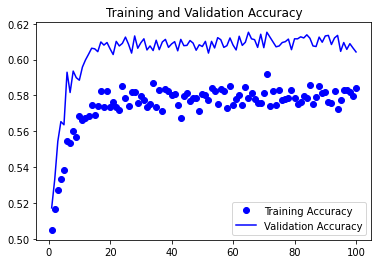

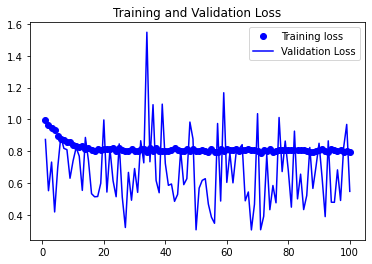

In [9]:
import matplotlib.pyplot as plt

acc = train_metrics.history['accuracy']
val_acc = train_metrics.history['val_accuracy']
loss = train_metrics.history['loss']
val_loss = train_metrics.history['val_loss']

epochs = range(1,len(acc) + 1)

plt.plot(epochs,acc,'bo',label = 'Training Accuracy')
plt.plot(epochs,val_acc,'b',label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'bo',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [12]:
#model.save_weights('modelhow m.h5') 